# Sport Image Classification (Using Convolutional Neural Network)

Collection of 100 different sport images. Total of 13572 samples. The classes are nearly balanced, number of samples for each class varies ~100-170

#### The Problem with the dataset

There are ~13572/100 = 135.72 samples for each class. Since the number of samples for each class is small, complex model easily overfits data and simple model is not able to find complex features for classifying sport images. Resnet50 V2 may be a good solution for this problem, which helps us to train deep networks with skip (shortcut) connections that reduces the chance of harming training set performance and having a vanishing gradient problem.

### Importing Libraries

In [1]:
import numpy as np
import os
from keras import layers
from keras import models
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping,ModelCheckpoint
import scipy
import tensorflow as tf 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor

In [2]:
train_directory = '../../Data/TrainSet'
valid_directory = '../../Data/ValidSet'
test_directory = '../../Data/TestSet'

In [3]:
for folder in os.listdir(train_directory):
    print(folder + ' -> ' + str(len([name for name in os.listdir('../../Data/TrainSet/'+str(folder))])))

air hockey -> 112
ampute football -> 112
archery -> 132
arm wrestling -> 99
axe throwing -> 113
balance beam -> 152
barell racing -> 123
baseball -> 174
basketball -> 169
baton twirling -> 108
bike polo -> 111
billiards -> 145
bmx -> 140
bobsled -> 138
bowling -> 120
boxing -> 116
bull riding -> 149
bungee jumping -> 125
canoe slamon -> 164
cheerleading -> 132
chuckwagon racing -> 120
cricket -> 130
croquet -> 136
curling -> 141
disc golf -> 123
fencing -> 135
field hockey -> 158
figure skating men -> 146
figure skating pairs -> 151
figure skating women -> 159
fly fishing -> 134
football -> 191
formula 1 racing -> 191
frisbee -> 133
gaga -> 118
giant slalom -> 151
golf -> 157
hammer throw -> 122
hang gliding -> 122
harness racing -> 147
high jump -> 159
hockey -> 172
horse jumping -> 137
horse racing -> 139
horseshoe pitching -> 102
hurdles -> 137
hydroplane racing -> 108
ice climbing -> 130
ice yachting -> 112
jai alai -> 132
javelin -> 136
jousting -> 118
judo -> 150
lacrosse -> 151


# Importing the dataset 

I will apply data augmentation, which not only is a variance reduction technique, but also may result in a better performance of the model. 

In [4]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True)

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size = (224,224),
        batch_size = 16,
        class_mode='categorical'
)

Found 13572 images belonging to 100 classes.


In [7]:
validation_generator = datagen.flow_from_directory(
        valid_directory,
        target_size=(224,224),
        batch_size = 16,
        class_mode = 'categorical'
)

Found 500 images belonging to 100 classes.


The base model is Resnet50 V2 model with 'imagenet' weights, without top layers

In [8]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    classes=100,
    classifier_activation='softmax',
    input_shape=(224,224,3)
)

First 170 layer weights won't be changed during training process, the weights of the layers after 170th will be trained on the dataset.
Two fully connected layers with relu activation and one output layer with softmax activation are added to the bottom of the model to be trained on the dataset too.

In [9]:
base_model.trainable = True

In [10]:
for layer in base_model.layers[:170]:
    layer.trainable = False

In [11]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8

The optimization algorithm used is RMSprop with learning rate = 0.0001. The metric is categorical accuracy.

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=metrics.metrics.categorical_accuracy)

C:\Users\hrayr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = 848,
        epochs = 20,
        validation_data = validation_generator,
        validation_steps = 31,
        verbose=1
)

Epoch 1/20


C:\Users\hrayr\AppData\Local\Temp\ipykernel_13164\2433559394.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


848/848 [==============================] - 98s 110ms/step - loss: 2.2129 - categorical_accuracy: 0.4630 - val_loss: 0.5689 - val_categorical_accuracy: 0.8145
Epoch 2/20
848/848 [==============================] - 96s 113ms/step - loss: 1.0485 - categorical_accuracy: 0.7148 - val_loss: 0.3205 - val_categorical_accuracy: 0.9073
Epoch 3/20
848/848 [==============================] - 98s 116ms/step - loss: 0.7675 - categorical_accuracy: 0.7866 - val_loss: 0.2489 - val_categorical_accuracy: 0.9355
Epoch 4/20
848/848 [==============================] - 100s 118ms/step - loss: 0.6167 - categorical_accuracy: 0.8294 - val_loss: 0.2178 - val_categorical_accuracy: 0.9335
Epoch 5/20
848/848 [==============================] - 99s 117ms/step - loss: 0.5310 - categorical_accuracy: 0.8505 - val_loss: 0.1837 - val_categorical_accuracy: 0.9476
Epoch 6/20
848/848 [==============================] - 102s 120ms/step - loss: 0.4488 - categorical_accuracy: 0.8733 - val_loss: 0.2103 - val_categorical_accuracy: 0.

The training and validation accuracies are ~96% and ~95% respectively. The result is much more better than the previous models. Let's see how it performs on test (unseen) data.

In [15]:
test_generator = datagen.flow_from_directory(
        test_directory,
        target_size=(224,224),
        batch_size = 16,
        class_mode = 'categorical'
)

Found 500 images belonging to 100 classes.


In [16]:
model.evaluate(test_generator)

32/32 [==============================] - 1s 34ms/step - loss: 0.1167 - categorical_accuracy: 0.9700


[0.1167035698890686, 0.9700000286102295]

Test set accuracy is 97%, which is a very good result!

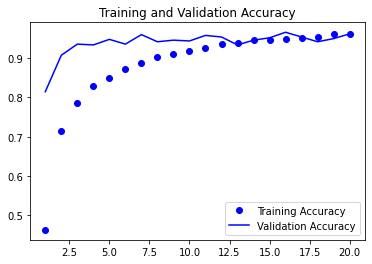

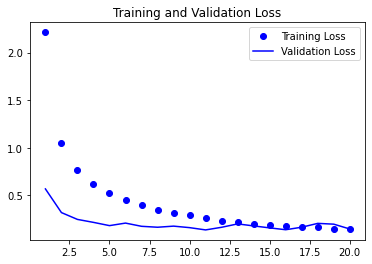

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
model.save('LastModel.h5')

In [20]:
import pickle

In [21]:
with open('./trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

## Conclusion

To conclude, transfer learning is a good way to try with small datasets. It uses weights trained on large datasets, which takes relevant parts of the pre-trained model and applies to the new problem. Resnet is a powerful model that makes it possible to train deep networks avoiding vanishing gradient problem. 